# ** Описание **

$$P(AB)=P(A|B)P(B)=P(B|A)P(A)$$
$$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$$
$$P(C|D)=\frac{P(D|C)P(C)}{P(D)}=\frac{P(x_1..x_n|C)P(C)}{P(D)}$$
Наивность заключается в том, что мы считаем все слова(признаки) независимыми между собой
$$P(x_1..x_n|C)=\prod_{i}^{n}P(x_i|C)$$

Соответственно тогда, вероятности того, что документ принадлежит каждому классу можно записат следующим образом

$$P(C|D)=\frac{\prod_{i}^{n}P(x_i|C)P(C)}{P(D)}$$
$$P(\neg C|D)=\frac{\prod_{i}^{n}P(x_i|\neg C)P(\neg C)}{P(D)}$$

Если поделить две эти вероятности, то мы сократим общие члены и упростим формулу

$$\frac{P(C|D)}{P(\neg C|D)}=\frac{\prod_{i}^{n}P(x_i|C)P(C)}{\prod_{i}^{n}P(x_i|\neg C)P(\neg C)}$$
$$ln\frac{P(C|D)}{P(\neg C|D)}=ln\frac{P(C)}{P(\neg C)}+\sum_{i}^{n}ln\frac{P(x_i|C)}{P(x_i|\neg C)}=$$
$$ln\frac{P(C)}{P(\neg C)}+\sum_{i}^{n}ln\frac{classCfreqX_i}{classNotCfreqX_i}$$
$$P(x_i|C)=classCfreqX_i/total$$
$$P(x_i|\neg C)=classNotCfreqX_i/total$$
$$ln\frac{P(C)}{P(\neg C)} = const$$
$$P(C|D) + P(\neg C|D) = 1$$

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib
import random

from collections import namedtuple
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 500
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Утилиты

#### Декораторы

In [3]:
def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
#from html.parser import HTMLParser
from HTMLParser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
#     word = ''
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print ('threshold %s' % threshold)
            print ('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print ('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print ('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
</html>
'''
test_url = 'http://ololo'
test_words = list(html2word(test_html_data))
for word in test_words:
    print (word)

заголовок
ololo
спам
1
2
3


In [11]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_class', 'url', 'words'])

def load_csv(input_file_name):    
    """
    Загружаем данные и извлекаем на лету слова
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            words = list(html2word(html_data))
            yield DocItem(url_id, mark, url, words)            
                
        trace(i, 1)        

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не порно, 1 - порно
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_class, url, html_data)

In [ ]:
TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

In [ ]:
train_docs = list(load_csv(TRAIN_DATA_FILE))

In [49]:
train_docs[1]

DocItem(doc_id=-9216194460302551143, is_class=False, url='http://stdrf.ru/node/1527', words=[u'\u044f', u'\u043c\u043e\u0433', u'\u0431\u044b\u0442\u044c', u'\u0441\u0447\u0430\u0441\u0442\u043b\u0438\u0432', u'\u0441\u0442\u0434', u'\u0440\u0444', u'cdata', u'jquery', u'extend', u'drupal', u'settings', u'basepath', u'thickbox', u'close', u'\u0437\u0430\u043a\u0440\u044b\u0442\u044c', u'next', u'\u0432\u043f\u0435\u0440\u0451\u0434', u'x3e', u'prev', u'x3c\u043d\u0430\u0437\u0430\u0434', u'esc', u'key', u'\u0438\u043b\u0438', u'\u043d\u0430\u0436\u043c\u0438\u0442\u0435', u'esc', u'next', u'close', u'next', u'close', u'on', u'last', u'image', u'count', u'\u0438\u0437\u043e\u0431\u0440\u0430\u0436\u0435\u043d\u0438\u0435', u'current', u'\u0438\u0437', u'total', u'popups', u'originalpath', u'node', u'1527', u'defaulttargetselector', u'div', u'left', u'corner', u'x3e', u'div', u'clear', u'block', u'last', u'modulepath', u'sites', u'all', u'modules', u'popups', u'autoclosefinalmessage', u'

In [44]:
a = {'a': 0, 'b' : 1}
b = {'c': 2, 'd' : 1}
'a' in a

True

** Классификатор: **
Нужно реализовать

In [111]:
import math
import collections
a = 0
b = 0
class Classifier:
    
    def __init__(self):
        self.trad_dict = collections.Counter()
        self.porn_dict = collections.Counter()
        self.trad_amount = 0
        self.porn_amount = 0
    
    def predict_porno(self, doc):        
        metric = 0
        porn = 0
        ne_porn = 0
        eps = 0.1
        all_w = 0
        for i in doc.words:
            if i in self.trad_dict:
                ne_porn = self.trad_dict[i]
            if i in self.porn_dict:
                porn = self.porn_dict[i]
            metric += math.log((eps + porn)/(eps + ne_porn))
            all_w += 1
        return metric/all_w
    
    def predict_random(self, doc):
        #Чтобы для каждого документа рандом был детерминирован
        random.seed(doc.doc_id)
        return random.random()

    def predict(self, doc):        
        return self.predict_porno(doc)
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_class, doc.url, prediction) )
        return res
    
    def train(self, docs):                
        for doc_num, doc in enumerate(docs):
            if doc.is_class:
                for i in doc.words:
                    self.porn_amount += 1
                    if i in self.porn_dict:
                        self.porn_dict[i] += 1
                    else:
                        self.porn_dict[i] = 1
                        
            else:
                for i in doc.words:
                    self.trad_amount += 1
                    if i in self.trad_dict:
                        self.trad_dict[i] += 1
                    else:
                        self.trad_dict[i] = 1
            trace(doc_num)
        global a
        global b
        a = self.porn_dict.most_common(20)
        b = self.trad_dict.most_common(20)
        trace(doc_num, 1)

In [118]:
a

[(u'\u0438', 22411),
 (u'\u0432', 18829),
 (u'var', 16955),
 (u'\u043f\u043e\u0440\u043d\u043e', 16113),
 (u'0', 14631),
 (u'\u043d\u0430', 12199),
 (u'1', 11983),
 (u'\u0444\u043e\u0442\u043e', 11168),
 (u'document', 11070),
 (u'a', 10135),
 (u'http', 9708),
 (u'\u0441', 9518),
 (u'ru', 8247),
 (u'\u0441\u0435\u043a\u0441', 7953),
 (u'\u043d\u0435', 7661),
 (u'\u0432\u0438\u0434\u0435\u043e', 7445),
 (u'2', 7210),
 (u'screen', 6597),
 (u'function', 6256),
 (u'if', 5296)]

In [115]:
b

[(u'\u0438', 83101),
 (u'\u0432', 80645),
 (u'\u043d\u0430', 41155),
 (u'0', 38556),
 (u'\u043d\u0435', 33488),
 (u'\u0441', 29085),
 (u'1', 27715),
 (u'a', 26928),
 (u'document', 22733),
 (u'\u0447\u0442\u043e', 21454),
 (u'var', 19686),
 (u'\u043f\u043e', 19008),
 (u'ru', 18622),
 (u'\u0434\u043b\u044f', 17391),
 (u'b', 15650),
 (u's', 15205),
 (u'2', 15011),
 (u'function', 14536),
 (u'\u0430', 14345),
 (u'\u043a\u0430\u043a', 14220)]

In [112]:
classifier = Classifier()
classifier.train(train_docs)

21:00:02 INFO:Complete items 00000
21:00:03 INFO:Complete items 00500
21:00:03 INFO:Complete items 01000
21:00:04 INFO:Complete items 01500
21:00:04 INFO:Complete items 02000
21:00:05 INFO:Complete items 02500
21:00:05 INFO:Complete items 03000
21:00:06 INFO:Complete items 03138


In [104]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_words))

-0.4958424972574939

** Рисуем графики **

20:53:18 INFO:Complete items 00000
20:53:18 INFO:Complete items 00500
20:53:19 INFO:Complete items 01000
20:53:20 INFO:Complete items 01500
20:53:21 INFO:Complete items 02000
20:53:21 INFO:Complete items 02500
20:53:22 INFO:Complete items 03000


threshold -3
	class_prec 0.390251672507, class_recall 1.0, class_F1 0.561411549038
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.280705774519
threshold -2.9
	class_prec 0.390251672507, class_recall 1.0, class_F1 0.561411549038
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.280705774519
threshold -2.8
	class_prec 0.390181702263, class_recall 0.999183673469, class_F1 0.56121045392
	not_class_prec 0.5, not_class_recall 0.000522466039707, not_class_F1 0.00104384133612
		MacroF1Mesure 0.281127147628
threshold -2.7
	class_prec 0.389987244898, class_recall 0.998367346939, class_F1 0.560880531988
	not_class_prec 0.333333333333, not_class_recall 0.000522466039707, not_class_F1 0.00104329681794
		MacroF1Mesure 0.280961914403
threshold -2.6
	class_prec 0.389987244898, class_recall 0.998367346939, class_F1 0.560880531988
	not_class_prec 0.333333333333, not_class_recall 0.000522466039707, not_class_F1 0.00104329681794
		MacroF1Mesure 0.

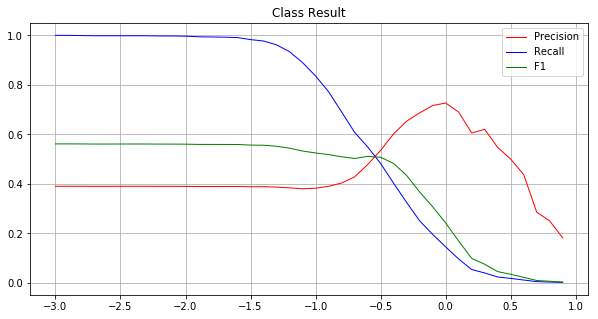

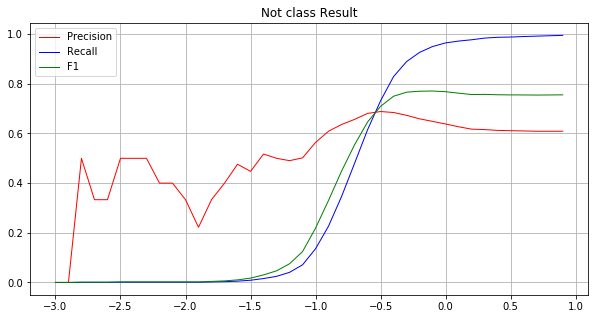

In [98]:
plot_results(train_docs, min_threshold=-3, max_threshold=1, step=0.1, trace=1)

In [99]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

test_docs = load_csv(TEST_DATA_FILE)

threshold = -0.5

with open('my_submission.csv' , 'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3] > threshold else 0
        writer.writerow([item[0], prediction])

20:53:47 INFO:Complete items 00000
20:53:47 INFO:Complete items 00000
20:53:54 INFO:Complete items 00500
20:53:54 INFO:Complete items 00500
20:54:02 INFO:Complete items 01000
20:54:02 INFO:Complete items 01000
20:54:03 INFO:Complete items 01075
